In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.pyplot as plt

In [2]:
#acollinearity function
def angleacoll(th1,th2,ph1,ph2):
    v1=[np.sin(th1)*np.cos(ph1),np.sin(th1)*np.sin(ph1),np.cos(th1)]
    v2=[np.sin(th2)*np.cos(ph2),np.sin(th2)*np.sin(ph2),np.cos(th2)]
    dot = np.dot(v1,v2)
    return (abs(np.pi-np.arccos(dot)))

#function that finds number of events in dataframe
#it identifies an events by pair event number and run number
def n_events_real(df):
    sumev = 0
    for item in df.groupby(['ievt', 'irun']).size():
        sumev = sumev + item
    return sumev

def n_events_mc(dfname, df_names, nevents_nom):
    index = df_names.index(dfname)
    return nevents_nom[index]

#find corresponding cross section given the channel
def dfxsec(dfname, df_names):
    index = df_names.index(dfname)
    return xsections[index]

#find scale factor by which each channel needs to be multiplied to match data
def scalefactor(lumi, n_events, xsec):
    return (xsec*lumi)/(n_events)

#log likelihood ratio
def LogLR(expBkg, expSig, obs):
    #avoid log of 0 using super small number #hack
    result = obs*np.log(max(expSig+expBkg, 0.000001)) - expSig - obs*np.log(max(expBkg,0.000001))
    return -2*result

In [3]:
#initial definitions

backgrounds = ['eeqq','qq','wen','ww','zee','zz']
backgrounds_cs = [15600,102,2.90,16.5,3.35,0.975] #pb


signals = ['higgs_85','higgs_90','higgs_95']
signal_cs = [0.0940,0.0667,0.0333] #pb
data = ['data']



#concatenate all the channels
channels = backgrounds + signals + data
xsections = backgrounds_cs + signal_cs
nevents_nom = [5940000,200000,81786,294500,29500,196000,3972,3973,3971]

#list which takes into account whether the channel is a background (bkg), signal (sgn), or data (data)
bkgsigdata = []

#dataframes lists
df_names = [] #need to work with names instead of just df because python cannot find a dataframe in a list of dataframes, so i just search by name
df_list = []
df_list_cut = []


#integrate luminosity
int_lumi = 176.773 #pb^-1

In [4]:
################################
# creation of all df and lists #
################################

for channel in channels:
    #fill the dataframes
    filename = '../l3higgs189/higgs_' + channel + '.csv'
    dfname = 'df_' + channel
    vars()[dfname] = pd.read_csv(filename)
       
    #add acollinearity and recoiling mass against jets
    angle = 180*np.pi/180
    recmass = []
    acollin = []
    for index, row in (vars()[dfname]).iterrows():
        #acollinearity
        acollin.append(angleacoll(row['thj1'],row['thj2'],row['phj1'],row['phj2']))            
    (vars()[dfname])['acoll'] = acollin
        
    
    #fill the bkgsigdata list, categorizing bkg, sgn, data
    if channel in backgrounds:
        bkgsigdata.append('bkg')
    elif channel in signals:
        bkgsigdata.append('sgn')
    elif channel in data:
        bkgsigdata.append('data')
        
    #fill dataframes lists
    df_names.append(dfname)
    df_list.append(vars()[dfname])
    

2.5
n signal events 85:  5.438484541792547
n signal events 90:  3.7571359226277368
n signal events 95:  1.766999937748678
n background events:  16.970592208796653
n data events:  21
2.5337680343994626
n signal events 85:  5.438484541792547
n signal events 90:  3.7571359226277368
n signal events 95:  1.766999937748678
n background events:  16.970592208796653
n data events:  21
2.5675360687989257
n signal events 85:  5.438484541792547
n signal events 90:  3.7571359226277368
n signal events 95:  1.766999937748678
n background events:  16.970592208796653
n data events:  21
2.6013041031983883
n signal events 85:  5.438484541792547
n signal events 90:  3.7571359226277368
n signal events 95:  1.766999937748678
n background events:  16.970592208796653
n data events:  21
2.6350721375978514
n signal events 85:  5.438484541792547
n signal events 90:  3.7571359226277368
n signal events 95:  1.766999937748678
n background events:  16.970592208796653
n data events:  21
2.668840171997314
n signal eve

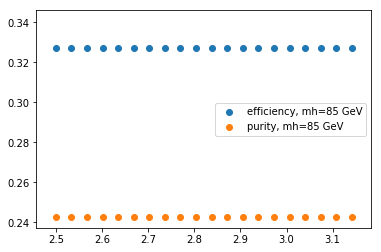

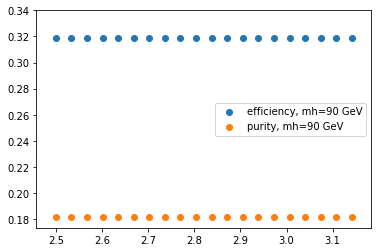

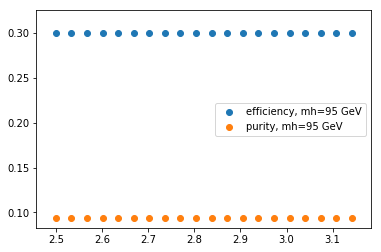

In [13]:
#########################
# plot signal/sqrt(bkg) #
#########################

df_list_cut = []

sigsqrtbkg_85 = []
sigsqrtbkg_90 = []
sigsqrtbkg_95 = []
eff_85 = []
eff_90 = []
eff_95 = []
pur_85 = []
pur_90 = []
pur_95 = []


#found by cell before, but putting ratio=4336.791864937596, without cuts
sgn_nocut_85 = 16.616661999999998
sgn_nocut_90 = 11.790759099999999
sgn_nocut_95 = 5.886540900000001

scatterxaxis = []

#btag
xrange_btag = np.linspace(0.1,0.9,20)
#mmis
xrange_mass = np.linspace(10,150,20)
#longitudinal missing momentum
xrange_acthm = np.linspace(0.4,1, 20)
#difference in phi of jets
xrange_acop = np.linspace(2.5,np.pi, 20)

#choose here which variable you want to cut
xrange = xrange_acop

for cutvalue in xrange:
    df_list_cut = []
    print(cutvalue)
    
    for dfname in df_names:
        index = df_names.index(dfname)
        tmpdf = (df_list[index])[(df_list[index])['mmis'] > 60]
        tmpdf = tmpdf[tmpdf['mmis'] < 120]
        tmpdf = tmpdf[tmpdf['acthm'] < 0.8]
        tmpdf = tmpdf[tmpdf['btag1'] > 0.2]
        tmpdf = tmpdf[tmpdf['btag2'] > 0.2]
        tmpdf = tmpdf[tmpdf['acop'] < 3.1]

        df_list_cut.append(tmpdf)


    nevents = [0]*len(df_list)


    for dfname in df_names:
        index = df_names.index(dfname)

        #backgrounds
        if bkgsigdata[index] == 'bkg':
            if(n_events_real(df_list_cut[index]) != 0):
                #calculate scale factor (xs) and plot histograms
                scalef = scalefactor(int_lumi, n_events_mc(dfname, df_names, nevents_nom), dfxsec(dfname, df_names))
                nevents[index]=(n_events_real(df_list_cut[index]))*scalef
            else: 
                nevents[index]=0

        #signals
        if bkgsigdata[index] == 'sgn':

            #calculate scale factor (xs) and plot histograms
            if(n_events_real(df_list_cut[index]) != 0):
                scalef = scalefactor(int_lumi, n_events_mc(dfname, df_names, nevents_nom), dfxsec(dfname, df_names))
                nevents[index]=(n_events_real(df_list_cut[index])*scalef)
            else: 
                nevents[index] = 0
        
        if bkgsigdata[index] == 'data':
            nevents[index]=(n_events_real(df_list_cut[index]))
  
        
    #print(nevents)

    bkg_ev = 0
    sgn_ev_85 = 0
    sgn_ev_90 = 0
    sgn_ev_95 = 0
    data_ev = 0

    for nev in nevents:
        index = nevents.index(nev)
        if bkgsigdata[index] == 'bkg':
            bkg_ev+=nev
        elif bkgsigdata[index] == 'sgn':
            if index == 6:
                sgn_ev_85+=nev
            elif index == 7:
                sgn_ev_90+=nev
            elif index == 8:
                sgn_ev_95+=nev
        elif bkgsigdata[index] == 'data':
            data_ev=nev
                
    if(bkg_ev != 0 and bkg_ev !=0 and bkg_ev != 0):
                   
        print('n signal events 85: ', sgn_ev_85)
        print('n signal events 90: ', sgn_ev_90)
        print('n signal events 95: ', sgn_ev_95)
        print('n background events: ', bkg_ev)
        print('n data events: ', data_ev)
        
        scatterxaxis.append(cutvalue)
        
        #efficiency = n signal events after cuts / n signal events before cuts\n
        eff_85.append(sgn_ev_85/sgn_nocut_85)
        eff_90.append(sgn_ev_90/sgn_nocut_90)
        eff_95.append(sgn_ev_95/sgn_nocut_95)
        #purity = n signal events after cuts / n signal+background events after cuts
        pur_85.append(sgn_ev_85/(sgn_ev_85+bkg_ev))
        pur_90.append(sgn_ev_90/(sgn_ev_90+bkg_ev))
        pur_95.append(sgn_ev_95/(sgn_ev_95+bkg_ev))
        #signal / sqrt(background)
        sigsqrtbkg_85.append(sgn_ev_85/np.sqrt(bkg_ev))
        sigsqrtbkg_90.append(sgn_ev_90/np.sqrt(bkg_ev))
        sigsqrtbkg_95.append(sgn_ev_95/np.sqrt(bkg_ev))



# signal/sqrt(bkg)
#plt.scatter(scatterxaxis,sigsqrtbkg_85, label='mh=85 GeV')
#plt.scatter(scatterxaxis,sigsqrtbkg_90, label='mh=90 GeV')
#plt.scatter(scatterxaxis,sigsqrtbkg_95, label='mh=95 GeV')
#plt.legend(loc='best')
#plt.show()

plt.scatter(scatterxaxis,eff_85, label='efficiency, mh=85 GeV')
plt.scatter(scatterxaxis,pur_85, label='purity, mh=85 GeV')
plt.legend(loc='best')
plt.show()

plt.scatter(scatterxaxis,eff_90, label='efficiency, mh=90 GeV')
plt.scatter(scatterxaxis,pur_90, label='purity, mh=90 GeV')
plt.legend(loc='best')
plt.show()

plt.scatter(scatterxaxis,eff_95, label='efficiency, mh=95 GeV')
plt.scatter(scatterxaxis,pur_95, label='purity, mh=95 GeV')
plt.legend(loc='best')
plt.show()



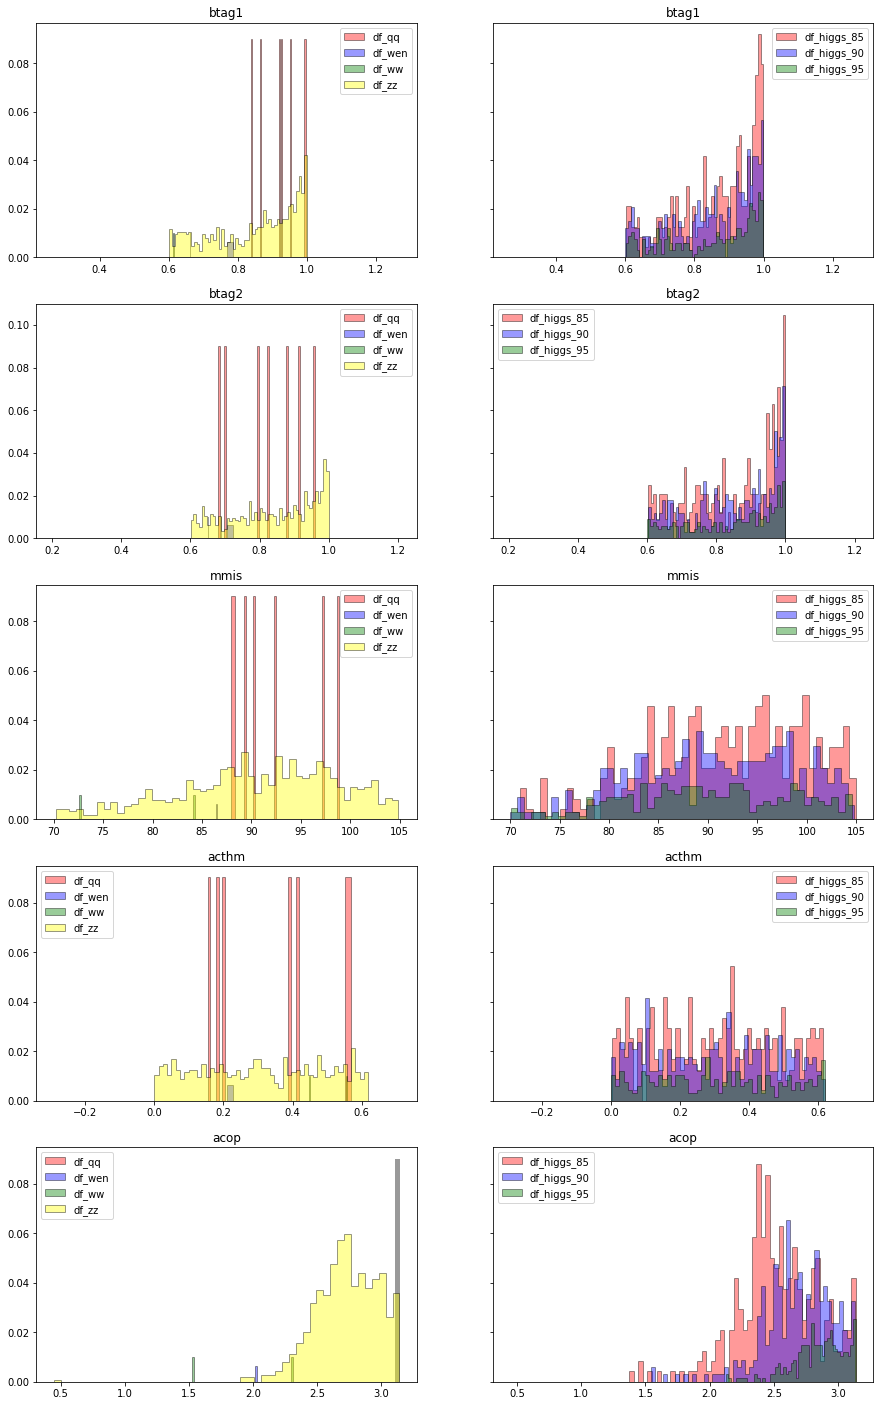

In [23]:
############################################################
# plot all variables for signal and background (WITH cuts) #
############################################################

#check variables for each channel, try to make some sense out of them and try to see possible cuts
varlist = ['btag1', 'btag2', 'mmis', 'acthm', 'acop']
varlength = len(varlist)

colors = ['yellow', 'red', 'blue', 'green', 'pink']
bins = 50

#plot each variable on each row
#left background, right signal(s)
df_list_cut = []


f, axs = plt.subplots(varlength, 2, sharey='row', sharex='row', figsize=(15,varlength*5))

for dfname in df_names:
    index = df_names.index(dfname)
    tmpdf = (df_list[index])[(df_list[index])['btag1'] > 0.6]
    tmpdf = tmpdf[tmpdf['btag2'] > 0.6]
    tmpdf = tmpdf[tmpdf['mmis'] > 70]
    tmpdf = tmpdf[tmpdf['mmis'] < 105]
    tmpdf = tmpdf[tmpdf['acthm'] < 0.62]
    #tmpdf = tmpdf[tmpdf['acop'] < 3.05]
    df_list_cut.append(tmpdf)
    

nevents = [0]*len(df_list)


for varname in varlist:
    index_var = varlist.index(varname)
    for dfname in df_names:
        index = df_names.index(dfname)

        #backgrounds
        if bkgsigdata[index] == 'bkg':
            #plot histograms (normalised area to 1)
            #axs[index_var,0].hist((df_list_cut[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
            if(n_events_real(df_list_cut[index]) != 0):
                #calculate scale factor (xs) and plot histograms
                scalef = scalefactor(int_lumi, n_events_mc(dfname, df_names, nevents_nom), dfxsec(dfname, df_names))
                weights = scalef*np.ones_like((df_list_cut[index])[varname])
                axs[index_var,0].hist(((df_list_cut[index])[varname]), bins=bins, weights=weights, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)

        #signals
        if bkgsigdata[index] == 'sgn':
            #plot histograms (normalised area to 1)
            #axs[index_var,1].hist((df_list_cut[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)

            #calculate scale factor (xs) and plot histograms
            if(n_events_real(df_list_cut[index]) != 0):
                scalef = scalefactor(int_lumi, n_events_mc(dfname, df_names, nevents_nom), dfxsec(dfname, df_names))
                weights = scalef*np.ones_like((df_list_cut[index])[varname])
                axs[index_var,1].hist(((df_list_cut[index])[varname]), bins=bins, weights=weights, color=colors[index%len(colors)], ec="black", histtype="stepfilled", label=dfname, alpha=0.4)
    #plot title and legend for background (left) and signal (right)
    axs[index_var,0].set_title(varname)
    axs[index_var,0].legend(loc='best')
    axs[index_var,1].set_title(varname)
    axs[index_var,1].legend(loc='best')


plt.show()
